# Modélisation avancé

In [1]:
import pandas as pd
import numpy as np 

import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, LSTM, Dropout, Flatten, SimpleRNN
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import matplotlib.pyplot as plt
plt.style.use("seaborn-darkgrid")

In [2]:
import spacy
from tensorboard.plugins.hparams import api as hp

In [3]:
dir_data = "./data/"
df_nlp = pd.read_csv(dir_data + "training.1600000.processed.noemoticon.csv",
                     encoding="ISO-8859-1",
                     header=None,
                     names=["target","id","date","flag","user","text"])

In [4]:
df_nlp.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df_nlp["sentiment"] = df_nlp["target"].apply(lambda x : "good" if x==4 else "bad").values

# Séparation jeu de données d'entrainement/test

In [6]:
from sklearn.model_selection import train_test_split

data_train,data_test = train_test_split(df_nlp,test_size=0.2,stratify=df_nlp["sentiment"],random_state=42)

In [7]:
data_train["sentiment"].value_counts()

good    640000
bad     640000
Name: sentiment, dtype: int64

In [8]:
X_train = data_train["text"].values
y_train = data_train["sentiment"].values

X_test = data_test["text"].values
y_test = data_test["sentiment"].values
print("train_set :",X_train.shape)
print("test_set :",X_test.shape)

train_set : (1280000,)
test_set : (320000,)


## Premier nettoyage des données

In [9]:
test_clean = "http://twitpic.com/2y1zl http://twitpic.com/2y1zl/ezfez489 https://twitpic.com/"
test_clean +=" http://192.168.1.1/test http://azure.microsoft.com/"
# remove url
print(test_clean)
def clean_url(sentence):
    sentence = re.sub('http[s]*://[0-9a-zA-Z-_.]*.[a-z]{0,3}/[0-9a-zA-Z-_./]*', '', sentence)
    return sentence

print("clean :", clean_url(test_clean))

http://twitpic.com/2y1zl http://twitpic.com/2y1zl/ezfez489 https://twitpic.com/ http://192.168.1.1/test http://azure.microsoft.com/
clean :     


In [10]:
# smile
test_clean = ";) xD xDDDDDD xP :D ;D ;d :) ^^ ^-^ :$ *-* :p ;p :o :S ;S :/ B)  ;( :( =) =D =$ =S =P =O :| =| ;| x) O_o o_O XO --\'"
# confusion, do not clean
test_clean += "\n\n:serpent xDeep :Departement :pertes :origan =Departement =pertes =Origan =$5 :$10"

# remove url
print(test_clean)
def clean_smile(sentence):
    sentence = re.sub(';\)','emote_clin_doeil ',sentence)
    sentence = re.sub(':\)|=\)','emote_sourire ',sentence)
    sentence = re.sub('x\)','emote_cross_smile ',sentence)
    sentence = re.sub('x{1,}[Dd]{1,}[^A-Za-z0-9]','emote_mdr ',sentence)
    sentence = re.sub(';[pP]{1,}[^A-Za-z0-9]|:[pP]{1,}[^A-Za-z0-9]|x[pP]{1,}[^A-Za-z0-9]|=[pP]{1,}[^A-Za-z0-9]',
                      'emote_tire_langue ',sentence)
    sentence = re.sub('[oO]_[oO]','emote_tres_surpris',sentence)
    sentence = re.sub('[Xx]{1,}[Oo]{1,}[^A-Za-z0-9]','emote_ko ',sentence)
    sentence = re.sub('[bB]\)[^A-Za-z0-9]','emote_lunette ',sentence)
    sentence = re.sub('[=:;][oO]{1,}[^A-Za-z0-9]','emote_surpris ',sentence)
    sentence = re.sub('[=:;][S]{1,}[^A-Za-z0-9]','emote_genant ',sentence)
    sentence = re.sub('[:;=][dD]{1,}[^A-Za-z0-9]','emote_gros_sourire ',sentence)
    sentence = re.sub('[:;=][$]{1,}[^A-Za-z0-9]','emote_genant_discret ',sentence)
    sentence = re.sub('[:;=]\|[^A-Za-z0-9]','emote_neutre ',sentence)
    sentence = re.sub('[:;=]/[^A-Za-z0-9]','emote_deception ',sentence)
    sentence = re.sub('[:;=]\([^A-Za-z0-9]','emote_insatisfait ',sentence)
    sentence = re.sub('\*[-_]\*[^A-Za-z0-9]','emote_magnifique ',sentence)
    sentence = re.sub('\^[-_]{0,1}\^[^A-Za-z0-9]','emote_joyeux ',sentence)
    sentence = re.sub('--\'[^A-Za-z0-9]','emote_enerve ',sentence)
    return sentence
print("-------------------------")
print("clean :",clean_smile(test_clean))

;) xD xDDDDDD xP :D ;D ;d :) ^^ ^-^ :$ *-* :p ;p :o :S ;S :/ B)  ;( :( =) =D =$ =S =P =O :| =| ;| x) O_o o_O XO --'

:serpent xDeep :Departement :pertes :origan =Departement =pertes =Origan =$5 :$10
-------------------------
clean : emote_clin_doeil  emote_mdr emote_mdr emote_tire_langue emote_gros_sourire emote_gros_sourire emote_gros_sourire emote_sourire  emote_joyeux emote_joyeux emote_genant_discret emote_magnifique emote_tire_langue emote_tire_langue emote_surpris emote_genant emote_genant emote_deception emote_lunette  emote_insatisfait emote_insatisfait emote_sourire  emote_gros_sourire emote_genant_discret emote_genant emote_tire_langue emote_surpris emote_neutre emote_neutre emote_neutre emote_cross_smile  emote_tres_surpris emote_tres_surpris emote_ko emote_enerve 
:serpent xDeep :Departement :pertes :origan =Departement =pertes =Origan =$5 :$10


In [11]:
test_clean = " jack &amp; martine say\" I love banana\" & &quot;And you&quot; &lt;a href=ettoutetout &gt;"
def clean_escape(sentence):
    sentence = re.sub('&amp;','&',sentence)
    sentence = re.sub('&quot;','\"',sentence)
    sentence = re.sub('&gt;','>',sentence)
    sentence = re.sub('&lt;','<',sentence)
    return sentence

print(test_clean)
print("--------------")
print("clean :",clean_escape(test_clean))

 jack &amp; martine say" I love banana" & &quot;And you&quot; &lt;a href=ettoutetout &gt;
--------------
clean :  jack & martine say" I love banana" & "And you" <a href=ettoutetout >


In [12]:
test_clean = "e same think p e lol it\'s fun 123 1 5 + 6 =11 aaaaaaaaa"
def clean_uniuque_char(sentence):
    sentence = " ".join([v for v in sentence.split(" ") if ((len(v) > 1) or (not v.isalpha()))])
    return sentence

print(test_clean)
print("--------------")
print("clean :",clean_uniuque_char(test_clean))

e same think p e lol it's fun 123 1 5 + 6 =11 aaaaaaaaa
--------------
clean : same think lol it's fun 123 1 5 + 6 =11 aaaaaaaaa


In [13]:
test_clean = X_train[489456]
print(test_clean)
def cleanning_data(sentence):
    sentence += " "
    sentence = re.sub('\n+', ' ', sentence.lower())
    # special caractère
    sentence = re.sub('[éèêë]','e',sentence)
    sentence = re.sub('[ïîì]','i',sentence)
    sentence = re.sub('[àâä]','a',sentence)
    sentence = re.sub('[ôö]','o',sentence) 
    sentence = re.sub('[üûù]','u',sentence)
    sentence = re.sub('[ç]','c',sentence)
    # personal_clean
    sentence = clean_escape(sentence) # usless ?
    sentence = clean_url(sentence)
    sentence = clean_smile(sentence)
    sentence = re.sub(r'[^a-z@#\'_ ]+',' ',sentence)
    sentence = clean_uniuque_char(sentence)
    sentence = re.sub(' {2,}', ' ', sentence)
    return sentence

print(cleanning_data(test_clean))

@AbbiDawson no but you only need to pay for plane tickets, you live with me  my mom thought it was a good idea ;)
@abbidawson no but you only need to pay for plane tickets you live with me my mom thought it was good idea emote_clin_doeil 


In [14]:
%%time
X_train = [cleanning_data(sentence) for sentence in X_train]

CPU times: user 51.1 s, sys: 53 ms, total: 51.2 s
Wall time: 51.2 s


In [15]:
print(X_train[0])

@paisleypaisley lol why do get ideas so far in advance it's not even june yet we need third knitter to have our own summer group 


## Stop_word /  lemmatization & stemming

In [14]:
nlp = spacy.load("en_core_web_sm",disable=["ner","parser"])
print(nlp.pipe_names)

['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer']


In [15]:
sw = nlp.Defaults.stop_words

In [17]:
%%time
lemmatization_data = [" ".join([w.lemma_.lower() for w in doc if not w.text.lower() in sw]) for doc in nlp.pipe(X_train, batch_size=2000, n_process=70)]

Wall time: 11min 54s


In [18]:
print(lemmatization_data[489456])

@abbidawson need pay plane ticket , live   mom think good idea ;)


In [19]:
number = 189498
print(lemmatization_data[number])
print()
print(X_train[number])

@stevehills & amp ; u refer drama work little . act class job .

@SteveHills &amp; if u were refering to the drama I was working on a little while back. It was for acting class not for a job. 


In [16]:
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [17]:
ps = PorterStemmer()

In [22]:
%%time
stemming_data = [" ".join([ps.stem(w) for w in nltk.word_tokenize(tweet) if not w in sw]) for tweet in X_train]

Wall time: 4min 54s


In [23]:
stemming_data[4]

'& quot ; so stand know i wo i wo gone & quot ; ... i miss home -a'

## Création de fonction (clean, vectorisation/word embedding)

In [18]:
sw = nlp.Defaults.stop_words
def basic_clean(docs,stop_word=True,multithreading = False ,n_process=70,batch_size=2000,stemming=False):
    new_docs = [cleanning_data(sentence) for sentence in docs]
    if stemming:
        ps = PorterStemmer()
        if stop_word:
            return [" ".join([ps.stem(w) for w in nltk.word_tokenize(tweet) if not w in sw]) for tweet in new_docs]
        else:
            return [" ".join([ps.stem(w) for w in nltk.word_tokenize(tweet)]) for tweet in new_docs]
    else:
        if multithreading:
            if stop_word:
                return [" ".join([w.lemma_.lower() for w in doc if not w.text.lower() in sw]) for doc in nlp.pipe(new_docs, batch_size=batch_size, n_process=n_process)]
            else:
                return [" ".join([w.lemma_.lower() for w in doc]) for doc in nlp.pipe(new_docs, batch_size=batch_size, n_process=n_process)]
        else:
            if stop_word:
                return [" ".join([w.lemma_.lower() for w in nlp(doc) if not w.text.lower() in sw]) for doc in new_docs]
            else:
                return [" ".join([w.lemma_.lower() for w in nlp(doc)]) for doc in new_docs]
    

In [26]:
tfidf = TfidfVectorizer(max_df=0.95,min_df=2)
# stemming
tfidf_stem = TfidfVectorizer(max_df=0.95,min_df=2)

In [27]:
%%time
tfidf_data = tfidf.fit_transform(lemmatization_data)

CPU times: user 8.43 s, sys: 0 ns, total: 8.43 s
Wall time: 8.46 s


In [28]:
%%time
tfidf_data_stem = tfidf_stem.fit_transform(stemming_data)

CPU times: user 8.44 s, sys: 0 ns, total: 8.44 s
Wall time: 8.44 s


In [29]:
print("Shape TF-IDF stem :",tfidf_data_stem.shape)
print("---------------------")
print("Shape TF-IDF :",tfidf_data.shape)

Shape TF-IDF stem : (1280000, 162651)
---------------------
Shape TF-IDF : (1280000, 170898)


In [30]:
def clean_transform_data(docs,stemming=False,multithreading=False):
    new_docs = basic_clean(docs,stemming=stemming,multithreading=multithreading)
    if stemming:
        return tfidf_stem.transform(new_docs)
    else:
        return tfidf.transform(new_docs)

# Test modèle "simple" (Bayes, Logistic_regression)

Pour la suite on utilisera comme métrice de performance principal, **l'AUC et l'accuracy (accuracy optionnel mais rajoute une information supplémentaire intéressante)** des modèles car nous avons un jeu de données équilibrés et une volonté de bien classé nos différent tweet / texte / documents sur la base d'un score de sentiment qui est plus parlant qu'une réponse binaire.

On analysera également **la matrice de confusion** avant d'analyser la classification des bon et mauvais tweet.

Actuellement la modèle doit classé correctement nos bad buzz mais notre manager "Marc" nous demande de généraliser notre solution, il est donc nécessaire d'avoir un juste millieux entre la classification correcte des bons et mauvais tweets / textes / documents, on utiliseras pour ça principalement **l'AUC** qui nous permet d'avoir un score des sentiment d'un tweet qui est bien plus parlant qu'une réposne binaire.

### NaiveBayes Sklearn
#### Stemming

In [31]:
from sklearn.naive_bayes import MultinomialNB

In [32]:
classifier_bayes = MultinomialNB()

In [33]:
classifier_bayes.fit(tfidf_data_stem,y_train)

MultinomialNB()

In [34]:
%%time
tfidf_test_stem = clean_transform_data(X_test,stemming=True)

CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 1min 46s


In [35]:
tfidf_test_stem.shape

(320000, 162651)

In [36]:
y_pred_prob = classifier_bayes.predict_proba(tfidf_test_stem)
y_pred = classifier_bayes.predict(tfidf_test_stem)

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
def show_result_binary(y_pred, y_pred_prob, y_true):
    print("accuracy score :",accuracy_score(y_test,y_pred))
    print("AUC score :",roc_auc_score(y_test,y_pred_prob[:,1]))
    cm = confusion_matrix(y_test,y_pred)
    print(classification_report(y_test,y_pred))
    return pd.DataFrame(cm,columns=["good","bad"],index=["good","bad"])

In [38]:
show_result_binary(y_pred,y_pred_prob,y_test)

accuracy score : 0.7498
AUC score : 0.8297499201757812
              precision    recall  f1-score   support

         bad       0.75      0.74      0.75    160000
        good       0.75      0.76      0.75    160000

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



,good,bad
good,118413,41587
bad,38477,121523


#### Lemmatization

In [39]:
%%time
classifier_bayes = MultinomialNB()
classifier_bayes.fit(tfidf_data,y_train)

CPU times: user 2.62 s, sys: 0 ns, total: 2.62 s
Wall time: 2.62 s


MultinomialNB()

In [40]:
%%time
tfidf_test = clean_transform_data(X_test,stemming=False,multithreading=True)

CPU times: user 2min 15s, sys: 11.9 s, total: 2min 27s
Wall time: 2min 28s


In [41]:
y_pred = classifier_bayes.predict(tfidf_test)
y_pred_prob = classifier_bayes.predict_proba(tfidf_test)

In [42]:
show_result_binary(y_pred,y_pred_prob,y_test)

accuracy score : 0.753075
AUC score : 0.8343503875585937
              precision    recall  f1-score   support

         bad       0.75      0.77      0.76    160000
        good       0.76      0.74      0.75    160000

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



,good,bad
good,122707,37293
bad,41723,118277


### Logistic_regression

Pour cette partie on cherchera le meilleur modèle qui optimisera l'AUC, et donc prédira le plus juste le sentiment d'un tweet sur la base d'un score de sentiment de négatif (0) à positif (1)

In [43]:
from sklearn.linear_model import LogisticRegression

In [44]:
lr_classifier = LogisticRegression(n_jobs=60)

### Stemming

In [45]:
%%time
tfidf_test_stem = clean_transform_data(X_test,stemming=True)

CPU times: user 1min 46s, sys: 0 ns, total: 1min 46s
Wall time: 1min 46s


In [46]:
%%time
lr_classifier.fit(tfidf_data_stem,y_train)

CPU times: user 1.32 s, sys: 1.02 s, total: 2.34 s
Wall time: 18.5 s


LogisticRegression(n_jobs=60)

In [47]:
y_pred = lr_classifier.predict(tfidf_test_stem)
y_pred_prob = lr_classifier.predict_proba(tfidf_test_stem)

In [48]:
print("Mot impactant positivement :",[tfidf_stem.get_feature_names()[lr_classifier.coef_.argsort()[0][::-1][i]] for i in range(20)])

Mot impactant positivement : ['thank', 'iamsoannoy', 'welcom', 'congratul', 'smile', 'fuzzbal', 'followfriday', 'tweeteradd', 'glad', 'congrat', 'proud', 'hehe', 'tweeterfollow', 'love', 'awesom', 'heheh', 'yay', 'pleasur', 'www', 'hihi']


In [49]:
print("Mot impactant négativement :",[tfidf_stem.get_feature_names()[lr_classifier.coef_.argsort()[0][i]] for i in range(20)])

Mot impactant négativement : ['sad', 'sadli', 'miss', 'poor', 'unfortun', 'sick', 'upset', 'bummer', 'depress', 'wish', 'disappoint', 'sadden', 'inaperfectworld', 'rip', 'cancel', 'hurt', 'suck', 'broke', 'cri', 'sorri']


In [50]:
show_result_binary(y_pred,y_pred_prob,y_test)

accuracy score : 0.769403125
AUC score : 0.8484383484765625
              precision    recall  f1-score   support

         bad       0.79      0.73      0.76    160000
        good       0.75      0.81      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



,good,bad
good,117258,42742
bad,31049,128951


### Lemmatization

In [51]:
lr_classifier = LogisticRegression(n_jobs=60).fit(tfidf_data,y_train)

In [52]:
%%time
tfidf_test = clean_transform_data(X_test,stemming=False,multithreading=True)

CPU times: user 2min 19s, sys: 10.2 s, total: 2min 29s
Wall time: 2min 27s


In [53]:
y_pred = lr_classifier.predict(tfidf_test)
y_pred_prob = lr_classifier.predict_proba(tfidf_test)

In [54]:
print("Mot impactant positivement :",[tfidf.get_feature_names()[lr_classifier.coef_.argsort()[0][::-1][i]] for i in range(20)])

Mot impactant positivement : ['thank', 'welcome', 'iamsoannoyed', 'congratulation', 'tweeteradd', 'smile', 'proud', 'tweeterfollow', 'fuzzball', 'glad', 'congrat', 'followfriday', 'pleasure', 'hehe', 'thx', 'yay', 'awesome', 'love', 'happy', 'hehehe']


In [55]:
print("Mot impactant négativement :",[tfidf.get_feature_names()[lr_classifier.coef_.argsort()[0][i]] for i in range(20)])

Mot impactant négativement : ['sad', 'miss', 'sadly', 'poor', 'unfortunately', 'disappointed', 'gutte', 'bummed', 'sick', 'wish', 'upset', 'bummer', 'cancel', 'hurt', 'depressing', 'cry', 'disappointing', 'suck', 'depressed', 'sadden']


In [56]:
show_result_binary(y_pred,y_pred_prob,y_test)

accuracy score : 0.771584375
AUC score : 0.8520599066210937
              precision    recall  f1-score   support

         bad       0.78      0.75      0.77    160000
        good       0.76      0.80      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



,good,bad
good,119689,40311
bad,32782,127218


## Optimisation Logistic_regression

On prendra pour l'optimisation le jeu de données avec lemmatization

In [57]:
from sklearn.model_selection import GridSearchCV

In [58]:
params = {
    "C":np.logspace(-5, 1, 20),
    "max_iter":[200,300,400],
}
Logistic_regression =  LogisticRegression(random_state=42,n_jobs=30)

In [59]:
grid = GridSearchCV(Logistic_regression,params,scoring="roc_auc",cv=5,n_jobs=30)

In [60]:
%%time
grid.fit(tfidf_data,y_train)

CPU times: user 18.9 s, sys: 1.56 s, total: 20.5 s
Wall time: 6min 11s


GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=30, random_state=42),
             n_jobs=30,
             param_grid={'C': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]),
                         'max_iter': [200, 300, 400]},
             scoring='roc_auc')

In [61]:
print("Le meilleur score est:",grid.best_score_,"\navec les paramètres suivant :",grid.best_params_)

Le meilleur score est: 0.8524477706359864 
avec les paramètres suivant : {'C': 1.1288378916846884, 'max_iter': 400}


In [62]:
best_classfier = grid.best_estimator_

In [63]:
y_pred = best_classfier.predict(tfidf_test)
y_pred_prob = best_classfier.predict_proba(tfidf_test)

In [64]:
show_result_binary(y_pred,y_pred_prob,y_test)

accuracy score : 0.7717375
AUC score : 0.8521386838085937
              precision    recall  f1-score   support

         bad       0.78      0.75      0.77    160000
        good       0.76      0.79      0.78    160000

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



,good,bad
good,119812,40188
bad,32856,127144


# Test modèle "avancé" (Classqiue DL,Glove, Word2Vec BERT, LSTM)

Les modèles "classique" obtiennes ici un score maximum de 0.85 d'AUC (Area Under the Curve) avec une matrice TF-IDF de tweet propre sur une régression logistique optimisé.

Ce score sera notre baseline de comparaison, le temps d'entrainement ici est très court avec 22 seconde d'entrainement sur 80% du jeu de données et création de la matrice TF-IDF + nettoyage des tweet en 11 minute ( 10 seconde seulement création matrice TF-IDF, 10 minute pour le nettoyage des stop_word et lemmatization et ensuite 50 seconde nettoyage simple des tweets)

Si on prend l'ensemble de la possible pipeline nous somme à environ **11 mintues 30 secondes et AUC à 0.85**.

In [19]:
# On reprend de 0
X_train = data_train["text"].values
y_train = data_train["sentiment"].values

X_test = data_test["text"].values
y_test = data_test["sentiment"].values
print("train_set :",X_train.shape)
print("test_set :",X_test.shape)

train_set : (1280000,)
test_set : (320000,)


In [20]:
new_size=100000
size=new_size//2

pos_X = []
i = 0
while len(pos_X) < size:
    if y_train[i] =="good":
        pos_X.append(X_train[i])
    i+=1
i=0
neg_X = []
while len(neg_X) < size:
    if y_train[i] =="bad":
        neg_X.append(X_train[i])
    i+=1
reduce_X = pos_X

reduce_X.extend(neg_X)
reduce_Y = ["good" for i in range(size)]
reduce_Y.extend(["bad" for i in range(size)])

In [21]:
new_size=40000
size=new_size//2

pos_X = []
i = 500000
while len(pos_X) < size:
    if y_train[i] =="good":
        pos_X.append(X_train[i])
    i+=1
i=500000
neg_X = []
while len(neg_X) < size:
    if y_train[i] =="bad":
        neg_X.append(X_train[i])
    i+=1
reduce_X_test = pos_X

reduce_X_test.extend(neg_X)
reduce_Y_test = ["good" for i in range(size)]
reduce_Y_test.extend(["bad" for i in range(size)])

## Démarche de recherche

1) La première étape ici consistera à vérifier la pertinance de faire de la lemmatisation ou du stemming pour l'amélioration d'algorithme de DL type (Embedding -> LSTM -> Dense)


2) Après ça on effectura un benchmark de plusieur type d'algorithme DL afin de trouver la meilleur structure :


- Modèle DL multicouche
- Modèle RNN Classique
- Modèle LSTM Embedding générer automatiquement
- Modèle LSTM avec Word2Vec 
- Modèle LSTM avec Glove
- Modèle Pré-entrainer BERT (Transfer-Learning)

3) Après avoir analysé plusieur modèle on choisira un modèle afin de l'optimiser.


4) Une fois la recherche d'hyperparamètre effectué, on générera notre modèle final grâce à une Pipeline.

## Recherche meilleur jeu de données

In [22]:
len(reduce_X)

100000

In [24]:
%%time
# regex clean + lemmatisation + stop word
X_1 = basic_clean(reduce_X,multithreading=True)
# regex clean + stemming + stop word
X_1_1 = basic_clean(reduce_X,stemming=True)
# regex clean + lemmatisation
X_2 = basic_clean(reduce_X,stop_word=False,multithreading=True)
# regex clean
X_3 = [cleanning_data(tweet) for tweet in reduce_X]
# Aucun clean
X_4 = reduce_X

CPU times: user 1min 52s, sys: 10.4 s, total: 2min 3s
Wall time: 2min 4s


In [25]:
%%time
# regex clean + lemmatisation + stop word
X_1_test = basic_clean(reduce_X_test,multithreading=True)
# regex clean + stemming + stop word
X_1_1_test = basic_clean(reduce_X_test,stemming=True)
# regex clean + lemmatisation
X_2_test = basic_clean(reduce_X_test,stop_word=False,multithreading=True)
# regex clean
X_3_test = [cleanning_data(tweet) for tweet in reduce_X_test]
# Aucun clean
X_4_test = reduce_X_test

CPU times: user 46.2 s, sys: 4.41 s, total: 50.6 s
Wall time: 53.6 s


In [26]:
def tokenize_data(data,tokenizer,maxlen=None):
    X = tokenizer.texts_to_sequences(data)
    return pad_sequences(X,maxlen=maxlen)

In [27]:
def get_basic_model(X,embed_dim = 128,lstm_out = 256,printing=True):
    model = Sequential()
    model.add(Embedding(10000, embed_dim,input_length = X.shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(lstm_out))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ["AUC",'accuracy'])
    if printing:
        print(model.summary())
    return model

In [28]:
%%time
dic_data = {}
dic_test = {}

# regex clean + lemmatisation + stop word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_1)
dic_data["clean_lemma_sw"] = tokenize_data(X_1,tokenizer,maxlen=100)
dic_test["clean_lemma_sw"] = tokenize_data(X_1_test,tokenizer,maxlen=100)


tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_1_1)
dic_data["clean_stemming_sw"] = tokenize_data(X_1_1,tokenizer,maxlen=100)
dic_test["clean_stemming_sw"] = tokenize_data(X_1_1_test,tokenizer,maxlen=100)

# regex clean + lemmatisation
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_2)
dic_data["clean_lemma"] = tokenize_data(X_2,tokenizer,maxlen=100)
dic_test["clean_lemma"] = tokenize_data(X_2_test,tokenizer,maxlen=100)

# regex clean
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_3)
dic_data["clean"] = tokenize_data(X_3,tokenizer,maxlen=100)
dic_test["clean"] = tokenize_data(X_3_test,tokenizer,maxlen=100)

# Aucun clean
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_4)
dic_data["no_clean"] = tokenize_data(X_4,tokenizer,maxlen=100)
dic_test["no_clean"] = tokenize_data(X_4_test,tokenizer,maxlen=100)

CPU times: user 16.1 s, sys: 324 ms, total: 16.5 s
Wall time: 16.4 s


In [29]:
print("Structure du modèle d\'entrainement :")
_= get_basic_model(dic_data["no_clean"],printing=True)

Structure du modèle d'entrainement :
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 128)          1280000   
_________________________________________________________________
dropout (Dropout)            (None, 100, 128)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 514       
Total params: 1,674,754
Trainable params: 1,674,754
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def show_result_binary(y_pred, y_pred_prob, y_true):
    print("accuracy score :",accuracy_score(y_test,y_pred))
    print("AUC score :",roc_auc_score(y_test,y_pred_prob[:,1]))
    cm = confusion_matrix(y_true,y_pred)
    print(classification_report(y_true,y_pred))
    return pd.DataFrame(cm,columns=["good","bad"],index=["good","bad"])

In [40]:
Y = pd.get_dummies(reduce_Y).values
y_test = reduce_Y_test
dic = {1:"good",0:"bad"}

for name, X in dic_data.items():
    print(name)
    model = get_basic_model(X,printing=False)
    trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(X,Y, test_size = 0.20,stratify=Y, random_state = 42)
    model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =32, epochs = 1)
    y_pred_proba = model.predict(dic_test[name])
    y_pred = np.argmax(y_pred_proba,axis=1)
    y_pred = [dic[y] for y in y_pred] 
    print(show_result_binary(y_pred,y_pred_proba,y_test))

clean_lemma_sw
2500/2500 [==============================] - 112s 45ms/step - loss: 0.5274 - auc: 0.8131 - accuracy: 0.7344 - val_loss: 0.4940 - val_auc: 0.8391 - val_accuracy: 0.7584
accuracy score : 0.749925
AUC score : 0.8344470975
              precision    recall  f1-score   support

         bad       0.74      0.77      0.76     20000
        good       0.76      0.73      0.74     20000

    accuracy                           0.75     40000
   macro avg       0.75      0.75      0.75     40000
weighted avg       0.75      0.75      0.75     40000

       good    bad
good  15417   4583
bad    5420  14580
clean_stemming_sw
2500/2500 [==============================] - 109s 43ms/step - loss: 0.5280 - auc: 0.8124 - accuracy: 0.7338 - val_loss: 0.4982 - val_auc: 0.8377 - val_accuracy: 0.7564
accuracy score : 0.750625
AUC score : 0.83492240625
              precision    recall  f1-score   support

         bad       0.77      0.71      0.74     20000
        good       0.73      0.79  

> On voit sur ces résultats que le jeu de données clean avec regex uniquement offre de meilleur résultat, ce qui peut sembler logique puisque plus le jeu de données et traiter plus on perd de l'information. Le "no-clean" ici semblent toute fois legerment plus performant MAIS detecte moins bien les bad buzz.  

In [59]:
X_train = [cleanning_data(tweet) for tweet in X_train]
X_test = [cleanning_data(tweet) for tweet in X_test]

In [60]:
Y = pd.get_dummies(y_train).values
test_Y = pd.get_dummies(y_test).values

## Recherche du meilleur modèles 

### Modèle multicouche dense

In [69]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [70]:
vocab_size = len(tokenizer.word_index) + 1
print("Taille du vocabulaire :",vocab_size)

Taille du vocabulaire : 505830


In [278]:
def get_model_dl_classic(X,printing=True,vocab_size=10000,dimension=100):
    model = Sequential()
    model.add(Embedding(vocab_size, dimension,input_length = X.shape[1]))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(Dropout(0.2))
    model.add(Dense(128))
    model.add(Dropout(0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['AUC',"accuracy"])
    if printing:
        print(model.summary())
    return model

In [269]:
x_train = tokenize_data(X_train,tokenizer,maxlen=200)

In [270]:
x_train.shape

(1280000, 200)

In [272]:
model = get_model_dl_classic(x_train,vocab_size=vocab_size,dimension=200)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 200)          101166000 
_________________________________________________________________
dropout_33 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               10240256  
_________________________________________________________________
dropout_34 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_35 (Dropout)         (None, 128)             

In [273]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
history = model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =256, epochs = 2)

Epoch 1/2
4000/4000 [==============================] - 130s 32ms/step - loss: 0.4674 - auc: 0.8639 - accuracy: 0.7868 - val_loss: 0.4433 - val_auc: 0.8773 - val_accuracy: 0.8013
Epoch 2/2
4000/4000 [==============================] - 130s 33ms/step - loss: 0.3629 - auc: 0.9200 - accuracy: 0.8478 - val_loss: 0.4795 - val_auc: 0.8666 - val_accuracy: 0.7919


In [29]:
def plot_history(history,scoring=["auc"],validation_scoring=True,margin_y=0.05,log_scale=False):
    scoring = [x.lower() for x in scoring]
    size_epoch=1
    all_val = []
    plot_enable=False
    for k in history.history.keys():
        if k in scoring:
            plot_enable=True
            break
    if plot_enable:
        plt.figure(figsize=(12,10))
        for k in history.history.keys():
            if k in scoring:
                plt.plot(history.history[k],label="train_set_"+k)
                if validation_scoring:
                    plt.plot(history.history["val_"+k],label="validation_set_"+k)
                all_val.extend(history.history[k])
                size_epoch = len(history.history[k])

        min_v = min(all_val) - margin_y
        max_v = max(all_val) + margin_y
        plt.ylim(min_v,max_v)
        plt.xticks([i for i in range(size_epoch)])
        plt.legend()
        if log_scale:
            plt.yscale("log")
        plt.show()
    else:
        print("No scoring match on :", history.history.keys())

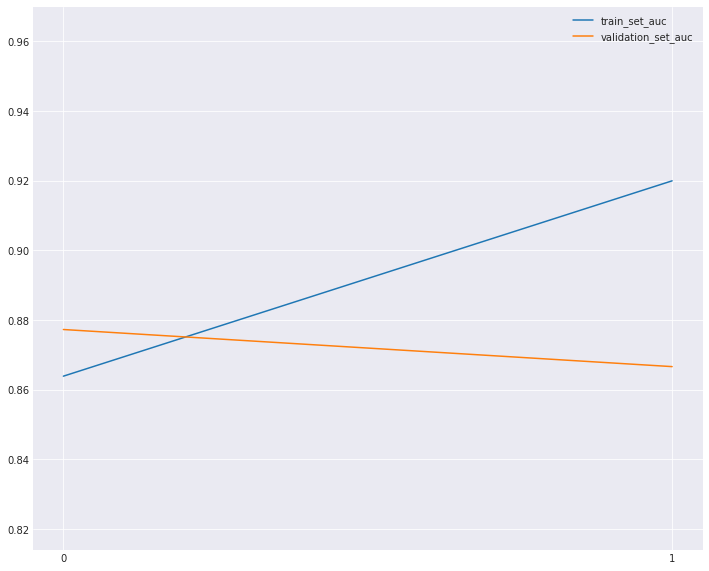

In [275]:
plot_history(history,scoring=["auc"])

## Modèle RNN classique Embedding générer automatiquement

In [69]:
def get_model_rnn(X,printing=True,vocab_size=10000,dimension=100):
    model = Sequential()
    model.add(Embedding(vocab_size, dimension,input_length = X.shape[1]))
    model.add(SimpleRNN(32,return_sequences =True))
    model.add(SimpleRNN(16,return_sequences =True))
    model.add(SimpleRNN(8))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['AUC',"accuracy"])
    if printing:
        print(model.summary())
    return model

In [70]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

x_train = tokenize_data(X_train,tokenizer,maxlen=150)
x_test = tokenize_data(X_test,tokenizer,maxlen=150)

In [71]:
vocab_size = len(tokenizer.word_index) + 1
print("Taille du vocabulaire :",vocab_size)

Taille du vocabulaire : 505830


In [80]:
model = get_model_rnn(x_train,vocab_size=vocab_size,dimension=200)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 150, 200)          101166000 
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 150, 32)           7456      
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 150, 16)           784       
_________________________________________________________________
simple_rnn_15 (SimpleRNN)    (None, 8)                 200       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 18        
Total params: 101,174,458
Trainable params: 101,174,458
Non-trainable params: 0
_________________________________________________________________
None


In [81]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
history = model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =1024, epochs = 2)

Epoch 1/2
1000/1000 [==============================] - 1338s 1s/step - loss: 0.4498 - auc: 0.8705 - accuracy: 0.7876 - val_loss: 0.4190 - val_auc: 0.8903 - val_accuracy: 0.8081
Epoch 2/2
1000/1000 [==============================] - 1410s 1s/step - loss: 0.3238 - auc: 0.9357 - accuracy: 0.8594 - val_loss: 0.4339 - val_auc: 0.8832 - val_accuracy: 0.8012


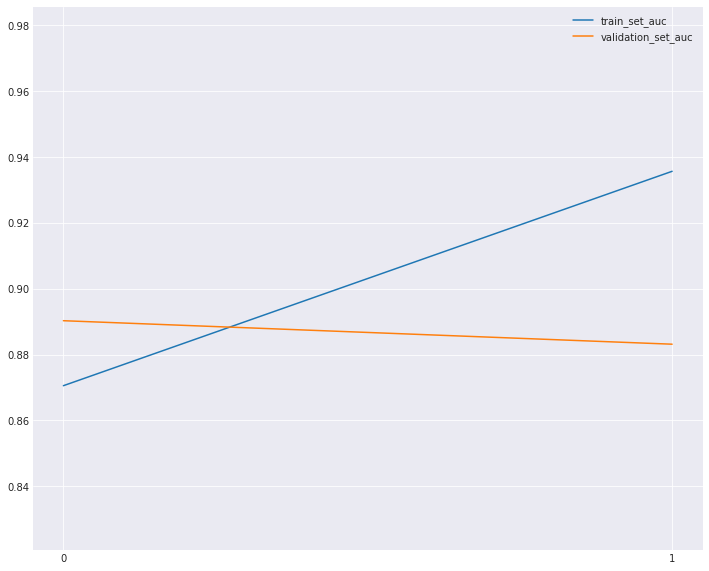

In [82]:
plot_history(history,scoring=["auc"])

## Modèle LSTM Embedding générer automatiquement

In [305]:
def get_model_lstm(X,printing=True,vocab_size=10000,dimension=100):
    model = Sequential()
    model.add(Embedding(vocab_size, dimension,input_length = X.shape[1]))
    model.add(Dropout(0.2))
    model.add(LSTM(512))
    model.add(Dropout(0.1))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['AUC',"accuracy"])
    if printing:
        print(model.summary())
    return model

In [306]:
model = get_model_lstm(x_train,vocab_size=vocab_size,dimension=200)

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 200, 200)          101166000 
_________________________________________________________________
dropout_50 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 512)               1460224   
_________________________________________________________________
dropout_51 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 1026      
Total params: 102,627,250
Trainable params: 102,627,250
Non-trainable params: 0
_________________________________________________________________
None


In [307]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
history = model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size =256, epochs = 2)

Epoch 1/2
4000/4000 [==============================] - 271s 67ms/step - loss: 0.4204 - auc: 0.8885 - accuracy: 0.8062 - val_loss: 0.3909 - val_auc: 0.9046 - val_accuracy: 0.8232
Epoch 2/2
4000/4000 [==============================] - 278s 70ms/step - loss: 0.3106 - auc: 0.9409 - accuracy: 0.8673 - val_loss: 0.4318 - val_auc: 0.8896 - val_accuracy: 0.8073


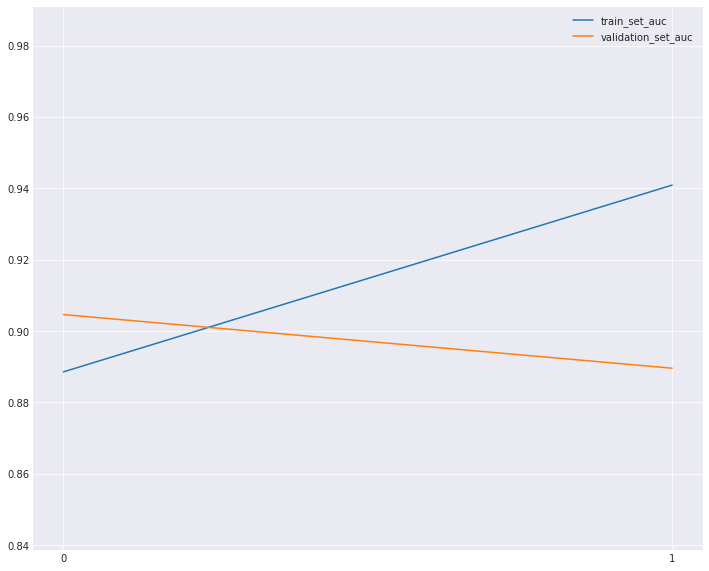

In [313]:
plot_history(history,scoring=["auc"])

In [311]:
model = get_model_lstm(x_train,vocab_size=vocab_size,dimension=200)
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size = 64, epochs = 1)

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_25 (Embedding)     (None, 200, 200)          101166000 
_________________________________________________________________
dropout_56 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 512)               1460224   
_________________________________________________________________
dropout_57 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 2)                 1026      
Total params: 102,627,250
Trainable params: 102,627,250
Non-trainable params: 0
_________________________________________________________________
None
16000/16000 [==============================] - 989s 62ms/step - loss: 0.4106 - auc: 0.8940 - accurac

In [316]:
model = get_model_lstm(x_train,vocab_size=vocab_size,dimension=200)
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size = 128, epochs = 1)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 200, 200)          101166000 
_________________________________________________________________
dropout_60 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 512)               1460224   
_________________________________________________________________
dropout_61 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 2)                 1026      
Total params: 102,627,250
Trainable params: 102,627,250
Non-trainable params: 0
_________________________________________________________________
None
8000/8000 [==============================] - 493s 61ms/step - loss: 0.4130 - auc: 0.8925 - accuracy:

## Modèle LSTM Word2Vec Embedding

In [317]:
def create_layer_embedding_word_2_vec(X, W2V_SIZE = 300, W2V_WINDOW = 7, W2V_EPOCH = 32,
                                      W2V_MIN_COUNT = 10, SEQUENCE_LENGTH = 300, workers=32):
    
    documents = [_text.split() for _text in X]
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, min_count=W2V_MIN_COUNT,workers=workers)
    w2v_model.build_vocab(documents)
    
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)
            
    embedding_layer_word_2_vec = Embedding(vocab_size, W2V_SIZE,
                                           weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
    
    return embedding_layer_word_2_vec

In [318]:
%%time
embedding = create_layer_embedding_word_2_vec(X_train)

CPU times: user 30min 57s, sys: 0 ns, total: 30min 57s
Wall time: 9min 31s


In [340]:
def get_model_lstm_embedding_pretrain(embedding,printing=True,metric=["AUC","accuracy"]):
    model = Sequential()
    model.add(embedding)
    model.add(Dropout(0.1))
    model.add(LSTM(256))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = metric)
    if printing:
        print(model.summary())
    return model

In [321]:
model=get_model_lstm_embedding_pretrain(embedding)

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 300, 300)          151749000 
_________________________________________________________________
dropout_62 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 256)               570368    
_________________________________________________________________
dropout_63 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 514       
Total params: 152,319,882
Trainable params: 570,882
Non-trainable params: 151,749,000
_________________________________________________________________
None


In [322]:
x_train = tokenize_data(X_train,tokenizer,maxlen=300)

In [323]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
history = model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size = 1024, epochs = 8)

Epoch 1/8
1000/1000 [==============================] - 90s 89ms/step - loss: 0.4601 - auc: 0.8642 - accuracy: 0.7828 - val_loss: 0.4253 - val_auc: 0.8856 - val_accuracy: 0.8031
Epoch 2/8
1000/1000 [==============================] - 91s 91ms/step - loss: 0.4176 - auc: 0.8899 - accuracy: 0.8072 - val_loss: 0.4085 - val_auc: 0.8957 - val_accuracy: 0.8132
Epoch 3/8
1000/1000 [==============================] - 92s 92ms/step - loss: 0.4026 - auc: 0.8983 - accuracy: 0.8157 - val_loss: 0.3949 - val_auc: 0.9026 - val_accuracy: 0.8203
Epoch 4/8
1000/1000 [==============================] - 91s 91ms/step - loss: 0.3931 - auc: 0.9033 - accuracy: 0.8208 - val_loss: 0.3880 - val_auc: 0.9060 - val_accuracy: 0.8241
Epoch 5/8
1000/1000 [==============================] - 90s 90ms/step - loss: 0.3854 - auc: 0.9072 - accuracy: 0.8250 - val_loss: 0.3832 - val_auc: 0.9084 - val_accuracy: 0.8264
Epoch 6/8
1000/1000 [==============================] - 93s 93ms/step - loss: 0.3781 - auc: 0.9109 - accuracy: 0.829

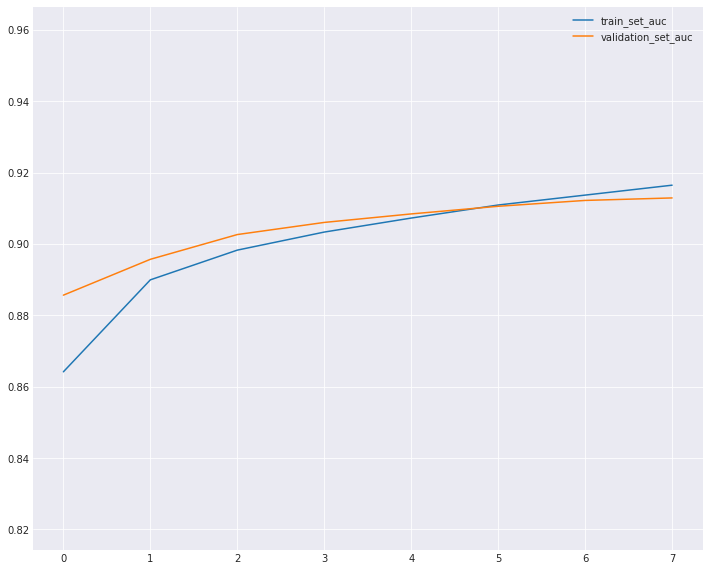

In [324]:
plot_history(history,scoring=["auc"])

In [345]:
model=get_model_lstm_embedding_pretrain(embedding,metric=["AUC"])

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 300, 300)          151749000 
_________________________________________________________________
dropout_72 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 256)               570368    
_________________________________________________________________
dropout_73 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 2)                 514       
Total params: 152,319,882
Trainable params: 570,882
Non-trainable params: 151,749,000
_________________________________________________________________
None


In [347]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
history = model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size = 1024, epochs = 8)

Epoch 1/8
1000/1000 [==============================] - 91s 90ms/step - loss: 0.4586 - auc: 0.8651 - val_loss: 0.4226 - val_auc: 0.8873
Epoch 2/8
1000/1000 [==============================] - 90s 90ms/step - loss: 0.4368 - auc: 0.8815 - val_loss: 0.4115 - val_auc: 0.8934
Epoch 3/8
1000/1000 [==============================] - 88s 88ms/step - loss: 0.4091 - auc: 0.8947 - val_loss: 0.4011 - val_auc: 0.8990
Epoch 4/8
1000/1000 [==============================] - 88s 88ms/step - loss: 0.4004 - auc: 0.8994 - val_loss: 0.3956 - val_auc: 0.9020
Epoch 5/8
1000/1000 [==============================] - 93s 93ms/step - loss: 0.4174 - auc: 0.8920 - val_loss: 0.3954 - val_auc: 0.9021
Epoch 6/8
1000/1000 [==============================] - 94s 94ms/step - loss: 0.3928 - auc: 0.9035 - val_loss: 0.3883 - val_auc: 0.9057
Epoch 7/8
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3870 - auc: 0.9065 - val_loss: 0.3856 - val_auc: 0.9072
Epoch 8/8
1000/1000 [==============================] - 

In [348]:
model=get_model_lstm_embedding_pretrain(embedding)

Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_28 (Embedding)     (None, 300, 300)          151749000 
_________________________________________________________________
dropout_74 (Dropout)         (None, 300, 300)          0         
_________________________________________________________________
lstm_31 (LSTM)               (None, 256)               570368    
_________________________________________________________________
dropout_75 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 514       
Total params: 152,319,882
Trainable params: 570,882
Non-trainable params: 151,749,000
_________________________________________________________________
None


In [349]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
history = model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size = 1024, epochs = 8)

Epoch 1/8
1000/1000 [==============================] - 93s 92ms/step - loss: 0.4564 - auc: 0.8666 - accuracy: 0.7853 - val_loss: 0.4223 - val_auc: 0.8875 - val_accuracy: 0.8049
Epoch 2/8
1000/1000 [==============================] - 93s 93ms/step - loss: 0.4175 - auc: 0.8901 - accuracy: 0.8076 - val_loss: 0.4041 - val_auc: 0.8974 - val_accuracy: 0.8148
Epoch 3/8
1000/1000 [==============================] - 97s 97ms/step - loss: 0.4013 - auc: 0.8990 - accuracy: 0.8165 - val_loss: 0.3947 - val_auc: 0.9029 - val_accuracy: 0.8211
Epoch 4/8
1000/1000 [==============================] - 98s 98ms/step - loss: 0.3921 - auc: 0.9038 - accuracy: 0.8211 - val_loss: 0.3871 - val_auc: 0.9068 - val_accuracy: 0.8258
Epoch 5/8
1000/1000 [==============================] - 97s 97ms/step - loss: 0.3838 - auc: 0.9081 - accuracy: 0.8259 - val_loss: 0.3823 - val_auc: 0.9089 - val_accuracy: 0.8274
Epoch 6/8
1000/1000 [==============================] - 96s 96ms/step - loss: 0.3776 - auc: 0.9112 - accuracy: 0.829

## Modèle LSTM Glove Embedding

https://www.kaggle.com/fullmetal26/glovetwitter27b100dtxt/download

In [325]:
%%time
import os
embeddings_index = {}
f = open(os.path.join('./data/glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.
CPU times: user 46.9 s, sys: 3.19 s, total: 50.1 s
Wall time: 1min 33s


In [328]:
def create_layer_embedding_glove(tokenizer,glove_embedding_pretrain,
                                 EMBEDDING_DIM=200,MAX_SEQUENCE_LENGTH=200):
    # Embedding
    word_index = tokenizer.word_index
    embedding_matrix = np.zeros((len(word_index) + 1, 200))
    for word, i in word_index.items():
        # vecteur d'un modèle glove pré-entrainé
        embedding_vector = glove_embedding_pretrain.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            
    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    
    return embedding_layer

In [329]:
x_train = tokenize_data(X_train,tokenizer,maxlen=200)

In [330]:
embedding_glove = create_layer_embedding_glove(tokenizer,embeddings_index)

In [333]:
model = get_model_lstm_embedding_pretrain(embedding_glove)

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, 200, 200)          101166000 
_________________________________________________________________
dropout_64 (Dropout)         (None, 200, 200)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 256)               467968    
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 514       
Total params: 101,634,482
Trainable params: 468,482
Non-trainable params: 101,166,000
_________________________________________________________________
None


In [334]:
trainset_X, validset_X, trainset_Y, validset_Y = train_test_split(x_train,Y, test_size = 0.20,stratify=Y, random_state = 42)
history = model.fit(trainset_X, trainset_Y,validation_data=(validset_X, validset_Y), batch_size = 1024, epochs = 8)

Epoch 1/8
1000/1000 [==============================] - 64s 63ms/step - loss: 0.4546 - auc: 0.8670 - accuracy: 0.7832 - val_loss: 0.4201 - val_auc: 0.8883 - val_accuracy: 0.8046
Epoch 2/8
1000/1000 [==============================] - 61s 61ms/step - loss: 0.4136 - auc: 0.8920 - accuracy: 0.8089 - val_loss: 0.4029 - val_auc: 0.8980 - val_accuracy: 0.8141
Epoch 3/8
1000/1000 [==============================] - 62s 62ms/step - loss: 0.3970 - auc: 0.9011 - accuracy: 0.8181 - val_loss: 0.3947 - val_auc: 0.9023 - val_accuracy: 0.8185
Epoch 4/8
1000/1000 [==============================] - 61s 61ms/step - loss: 0.3845 - auc: 0.9076 - accuracy: 0.8253 - val_loss: 0.3876 - val_auc: 0.9063 - val_accuracy: 0.8235
Epoch 5/8
1000/1000 [==============================] - 61s 61ms/step - loss: 0.3743 - auc: 0.9127 - accuracy: 0.8304 - val_loss: 0.3823 - val_auc: 0.9089 - val_accuracy: 0.8265
Epoch 6/8
1000/1000 [==============================] - 61s 61ms/step - loss: 0.3648 - auc: 0.9172 - accuracy: 0.835

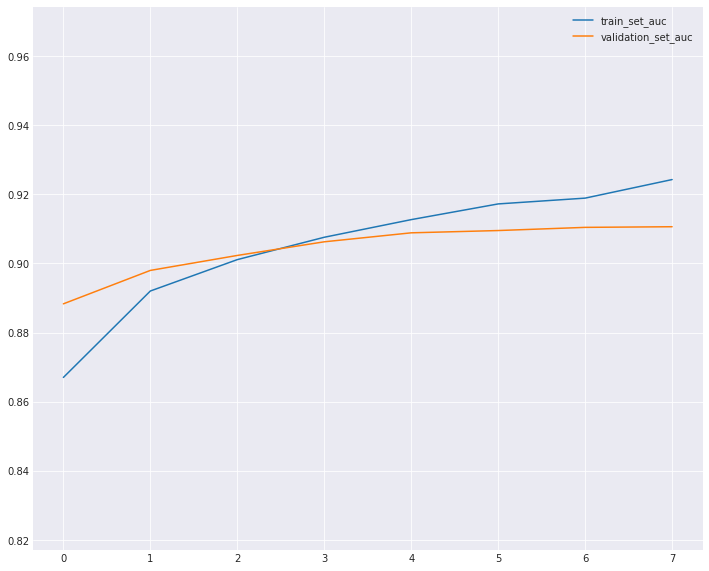

In [335]:
plot_history(history,scoring=["auc"])

## Modèle pré-entrainer BERT (Transfer-learning)

In [19]:
from transformers import AutoTokenizer, TFAutoModel
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = TFAutoModel.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [25]:
SEQ_LEN=128
def prepare_data(data,labels):
    Xids = np.zeros((len(data), SEQ_LEN))
    Xmask = np.zeros((len(data), SEQ_LEN))
    Y = pd.get_dummies(labels).values
    # tokenize data
    for i, sentence in enumerate(data):
        Xids[i, :], Xmask[i, :] = tokenize(sentence)
        
    dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, Y))
    
    dataset = dataset.map(map_func) 
    
    return dataset.shuffle(10000).batch(32)
    
    
# restructure dataset format for BERT
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

def tokenize(sentence):
    tokens = tokenizer.encode_plus(sentence, max_length=SEQ_LEN,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_attention_mask=True,
                                   return_token_type_ids=False, return_tensors='tf')
    return tokens['input_ids'], tokens['attention_mask']


In [26]:
%%time
dataset_train = prepare_data(X_train,y_train)

CPU times: user 3min 16s, sys: 846 ms, total: 3min 17s
Wall time: 3min 17s


In [27]:
%%time
dataset_test = prepare_data(X_test,y_test)

CPU times: user 50.5 s, sys: 230 ms, total: 50.7 s
Wall time: 50.7 s


In [156]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]  # we only keep tensor 0 (last_hidden_state)

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)  # reduce tensor dimensionality
X = tf.keras.layers.BatchNormalization()(X)
X = tf.keras.layers.Dense(128, activation='relu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X)  # 3 labels due to three sentiment classes

model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model.layers[2].trainable = False

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 768)          0           tf_bert_model[1][0]        

In [157]:
history = model.fit(dataset_train, epochs=1)

40000/40000 [==============================] - 6429s 161ms/step - loss: 0.5333 - auc: 0.8081 - accuracy: 0.7303


In [162]:
_,auc,acc = model.evaluate(dataset_test)
print("Validation Accuracy: %.2f" % (acc))
print("Validation AUC: %.2f" % (auc))

10000/10000 [==============================] - 1378s 138ms/step - loss: 0.5003 - auc: 0.8355 - accuracy: 0.7527
Validation Accuracy: 0.75
Validation AUC: 0.84


In [167]:
input_ids = tf.keras.layers.Input(shape=(SEQ_LEN,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(SEQ_LEN,), name='attention_mask', dtype='int32')

embeddings = bert(input_ids, attention_mask=mask)[0]  # we only keep tensor 0 (last_hidden_state)

X = tf.keras.layers.LSTM(256)(embeddings)
X = tf.keras.layers.Dropout(0.2)(X)
y = tf.keras.layers.Dense(2, activation='softmax', name='outputs')(X) 

model_lstm_bert = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

model_lstm_bert.layers[2].trainable = False

model_lstm_bert.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

model_lstm_bert.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 256)          1049600     tf_bert_model[4][0]        

In [168]:
history = model_lstm_bert.fit(dataset_train,batch_size=128, epochs=1)

40000/40000 [==============================] - 7005s 175ms/step - loss: 0.4527 - auc: 0.8690 - accuracy: 0.7877


In [169]:
_,auc,acc = model_lstm_bert.evaluate(dataset_test)
print("Validation Accuracy: %.2f" % (acc))
print("Validation AUC: %.2f" % (auc))

10000/10000 [==============================] - 1541s 154ms/step - loss: 0.4136 - auc: 0.8931 - accuracy: 0.8108
Validation Accuracy: 0.81
Validation AUC: 0.89


# Full train - reduce_data

In [21]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

# bert_model_cls = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
# tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")

In [15]:
bert_model_cls.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_37 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [16]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN], 
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)
    return train_InputExamples, validation_InputExamples

def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer_bert.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield ({
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },f.label,)
            
    return tf.data.Dataset.from_generator( gen,
            ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        ({
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },tf.TensorShape([]),),
    )
def prepare_data_classification_bert(X_train,X_test,y_train,y_test):
    dic = {"good":1,"bad":0}
    labels_train = [dic[y] for y in y_train]
    labels_test = [dic[y] for y in y_test]
    DATA_COLUMN = 'DATA_COLUMN'
    LABEL_COLUMN = 'LABEL_COLUMN'
    train = pd.DataFrame([X_train,labels_train],index=[DATA_COLUMN,LABEL_COLUMN]).T
    test =  pd.DataFrame([X_test,labels_test],index=[DATA_COLUMN,LABEL_COLUMN]).T
    train_InputExamples, validation_InputExamples = convert_data_to_examples(train,test,DATA_COLUMN, LABEL_COLUMN)
    
    train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer_bert)
    train_data = train_data.shuffle(100).batch(32).repeat(2)

    validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer_bert)
    validation_data = validation_data.batch(32)
    return train_data,validation_data

In [26]:
%%time
train_data_reduce, validation_data_reduce = prepare_data_classification_bert(reduce_X,reduce_X_test,reduce_Y,reduce_Y_test)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2218: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


CPU times: user 1min 5s, sys: 0 ns, total: 1min 5s
Wall time: 1min 5s


In [166]:
%%time
train_data, validation_data = prepare_data_classification_bert(X_train,X_test,y_train,y_test)

CPU times: user 9min 53s, sys: 2.78 s, total: 9min 55s
Wall time: 9min 55s


In [27]:
bert_model_cls.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

bert_model_cls.fit(train_data_reduce, epochs=1, validation_data=validation_data_reduce)

6250/6250 [==============================] - 3176s 505ms/step - loss: 0.0113 - accuracy: 0.9981 - val_loss: 5.4457 - val_accuracy: 0.5000


## Résultat

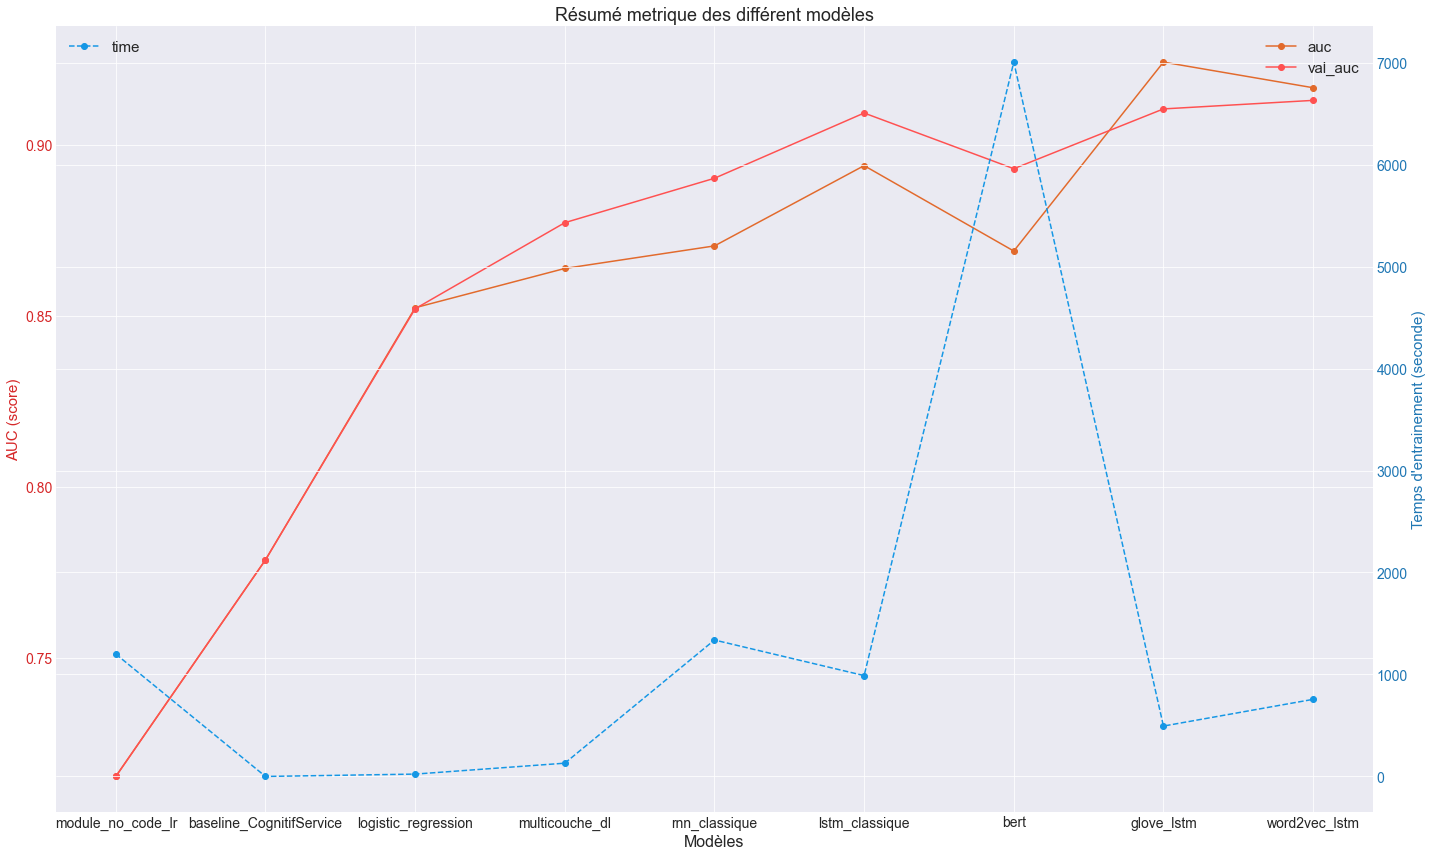

In [20]:
result_final = {
    "module_no_code_lr":{"auc":0.7152,"val_auc":0.7152,"nb_data":10000,"time":1200},
    "baseline_CognitifService":{"auc":0.7786,"val_auc":0.7786,"nb_data":0,"time":0},
    "logistic_regression":{"auc":0.8524,"val_auc":0.8521,"nb_data":1600000,"time":23},
    "multicouche_dl":{"auc":0.8639,"val_auc":0.8773,"nb_data":1280000,"time":130},
    "rnn_classique":{"auc":0.8705,"val_auc":0.8903,"nb_data":1280000,"time":1338},
    "lstm_classique":{"auc":0.8940,"val_auc":0.9094,"nb_data":1280000,"time":989},
    "bert":{"auc":0.8690,"val_auc":0.8931,"nb_data":1280000,"time":7005},
    "glove_lstm":{"auc":0.9243,"val_auc":0.9106,"nb_data":1280000,"time":494},
    "word2vec_lstm":{"auc":0.9168,"val_auc":0.9131,"nb_data":1280000,"time":756},
    # pour optimize on à entrainé sur tout le jeu de données "acc" puis test sur le jeu de test "val_acc" 
#     "word2vec_lstm_optimize":{"auc":0.9258,"val_auc":0.9234,"nb_data":1600000,"time":890},
}

fig, ax1 = plt.subplots(figsize=(20,12))
ax1.set_xlabel("Modèles",fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.set_ylabel("AUC (score)",color='tab:red',fontsize=15)
ax1.plot([k for k in result_final.keys()],[v["auc"] for v in result_final.values()],label="auc",color="#E26A2C",marker="o")
ax1.plot([k for k in result_final.keys()],[v["val_auc"] for v in result_final.values()],label="val_auc",color="#FF5151",marker="o")
ax1.tick_params(axis='y', labelcolor='tab:red',labelsize=14)

ax2 = ax1.twinx()

ax2.plot([k for k in result_final.keys()],[v["time"] for v in result_final.values()],
         label="time",color="#1597E5",marker="o",ls="--")
ax2.set_ylabel('Temps d\'entrainement (secondes)', color='tab:blue',fontsize=15) 
ax2.tick_params(axis='y', labelcolor='tab:blue',labelsize=14)

plt.title("Résumé des différents modèles",fontsize=18)
ax1.legend(loc="upper right",fontsize=15)
ax2.legend(loc="upper left",fontsize=15)
fig.tight_layout()
plt.show()

# Optimisation model (fine tuning)

## Word2Vec

In [26]:
import gensim

def create_layer_embedding_word_2_vec(X, W2V_SIZE = 300, W2V_WINDOW = 7, W2V_EPOCH = 32,
                                      W2V_MIN_COUNT = 10, SEQUENCE_LENGTH = [150,300], workers=32):
    
    documents = [_text.split() for _text in X]
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, min_count=W2V_MIN_COUNT,workers=workers)
    w2v_model.build_vocab(documents)
    
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)
            
    embedding_layer_word_2_vec_150 = Embedding(vocab_size, W2V_SIZE,
                                           weights=[embedding_matrix], input_length=SEQUENCE_LENGTH[0], trainable=False)
    embedding_layer_word_2_vec_300 = Embedding(vocab_size, W2V_SIZE,
                                           weights=[embedding_matrix], input_length=SEQUENCE_LENGTH[1], trainable=False)
    
    return embedding_layer_word_2_vec_150,embedding_layer_word_2_vec_300

In [22]:
# On reprend de 0
X_train = data_train["text"].values
y_train = data_train["sentiment"].values

X_test = data_test["text"].values
y_test = data_test["sentiment"].values
print("train_set :",X_train.shape)
print("test_set :",X_test.shape)

train_set : (1280000,)
test_set : (320000,)


In [23]:
X = [cleanning_data(sentence) for sentence in X_train]
Y = pd.get_dummies(y_train).values

In [25]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([128,256]))
# HP_DROPOUT = hp.HParam("dropout",hp.RealInterval(0.1, 0.2))
HP_DIMENSION_EMBEDDING = hp.HParam('dimension_embedding_vec', hp.Discrete([200,300]))
HP_DIMENSION_SEQ = hp.HParam('dimension_seq', hp.Discrete([150,300]))

In [24]:
dic_seq = {}
dic_embedding={}
dic_embedding[200] =  {}
dic_embedding[300] =  {}

In [27]:
%%time

emb150,emb300 = create_layer_embedding_word_2_vec(X,W2V_SIZE=200)

dic_embedding[200][150]=emb150
dic_embedding[200][300]=emb300

CPU times: user 25min 42s, sys: 15.1 s, total: 25min 57s
Wall time: 8min 54s


In [28]:
%%time

emb150,emb300 = create_layer_embedding_word_2_vec(X,W2V_SIZE=300)

dic_embedding[300][150]=emb150
dic_embedding[300][300]=emb300

CPU times: user 30min 3s, sys: 17.9 s, total: 30min 21s
Wall time: 8min 56s


In [30]:
test_X = [cleanning_data(sentence) for sentence in X_test]
test_Y = pd.get_dummies(y_test).values

In [31]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
x_train = pad_sequences(tokenizer.texts_to_sequences(X),maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_X),maxlen=300)
dic_seq[300] = (x_train,x_test)
x_train = pad_sequences(tokenizer.texts_to_sequences(X),maxlen=150)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_X),maxlen=150)
dic_seq[150] = (x_train,x_test)

CPU times: user 1min 5s, sys: 843 ms, total: 1min 6s
Wall time: 1min 6s


In [43]:
METRIC_ACCURACY = 'accuracy'
METRIC_AUC = "AUC"
path = './logs/hparam_tuning'


with tf.summary.create_file_writer(path).as_default():
    hp.hparams_config(
        hparams=[HP_NUM_UNITS,HP_DIMENSION_EMBEDDING,HP_DIMENSION_SEQ],
        metrics=[hp.Metric(METRIC_AUC, display_name='AUC'),hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )
    session_num = 0
    
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy,auc = train_test_model(hparams)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)
        tf.summary.scalar(METRIC_AUC, auc, step=1)

history_list = []

def train_test_model(hparams):
    model = Sequential()
    model.add(dic_embedding[hparams[HP_DIMENSION_EMBEDDING]][hparams[HP_DIMENSION_SEQ]])
    model.add(LSTM(hparams[HP_NUM_UNITS]))
    model.add(Dropout(0.1))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['AUC',"accuracy"],
    )
    
    x_train,x_test = dic_seq[hparams[HP_DIMENSION_SEQ]]
    history = model.fit(x_train, Y, epochs=8, batch_size=1024,validation_data=(x_test,test_Y)) 
    history_list.append(history)
    _, accuracy,auc = model.evaluate(x_test, test_Y,batch_size=1024)
    return accuracy,auc

In [44]:
for num_units in HP_NUM_UNITS.domain.values:
    for dim_emb in HP_DIMENSION_EMBEDDING.domain.values:
        for dim_seq in HP_DIMENSION_SEQ.domain.values:
            hparams = {
                HP_NUM_UNITS: num_units,
                HP_DIMENSION_EMBEDDING: dim_emb,
                HP_DIMENSION_SEQ: dim_seq,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run(path + "/" + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 128, 'dimension_embedding_vec': 200, 'dimension_seq': 150}
Epoch 1/8
1250/1250 [==============================] - 56s 43ms/step - loss: 0.4496 - auc: 0.8709 - accuracy: 0.7897 - val_loss: 0.4196 - val_auc: 0.8890 - val_accuracy: 0.8070
Epoch 2/8
1250/1250 [==============================] - 52s 42ms/step - loss: 0.4110 - auc: 0.8937 - accuracy: 0.8112 - val_loss: 0.4036 - val_auc: 0.8978 - val_accuracy: 0.8164
Epoch 3/8
1250/1250 [==============================] - 51s 41ms/step - loss: 0.3972 - auc: 0.9011 - accuracy: 0.8191 - val_loss: 0.3928 - val_auc: 0.9035 - val_accuracy: 0.8223
Epoch 4/8
1250/1250 [==============================] - 53s 42ms/step - loss: 0.3888 - auc: 0.9055 - accuracy: 0.8236 - val_loss: 0.3889 - val_auc: 0.9057 - val_accuracy: 0.8239
Epoch 5/8
1250/1250 [==============================] - 51s 41ms/step - loss: 0.3824 - auc: 0.9088 - accuracy: 0.8270 - val_loss: 0.3830 - val_auc: 0.9085 - val_accuracy: 0.8269
Epoch 6/8
1250/1

Epoch 1/8
1250/1250 [==============================] - 105s 83ms/step - loss: 0.4641 - auc: 0.8617 - accuracy: 0.7815 - val_loss: 0.4262 - val_auc: 0.8851 - val_accuracy: 0.8025
Epoch 2/8
1250/1250 [==============================] - 104s 83ms/step - loss: 0.4161 - auc: 0.8908 - accuracy: 0.8081 - val_loss: 0.4042 - val_auc: 0.8975 - val_accuracy: 0.8155
Epoch 3/8
1250/1250 [==============================] - 104s 83ms/step - loss: 0.4001 - auc: 0.8996 - accuracy: 0.8171 - val_loss: 0.3958 - val_auc: 0.9020 - val_accuracy: 0.8205
Epoch 4/8
1250/1250 [==============================] - 104s 83ms/step - loss: 0.3917 - auc: 0.9040 - accuracy: 0.8221 - val_loss: 0.3885 - val_auc: 0.9058 - val_accuracy: 0.8244
Epoch 5/8
1250/1250 [==============================] - 104s 83ms/step - loss: 0.3827 - auc: 0.9087 - accuracy: 0.8268 - val_loss: 0.3817 - val_auc: 0.9092 - val_accuracy: 0.8283
Epoch 6/8
1250/1250 [==============================] - 103s 83ms/step - loss: 0.3761 - auc: 0.9119 - accuracy:

In [8]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [11]:
%tensorboard --logdir logs/hparam_tuning --host 0.0.0.0
# %tensorboard --logdir logs/hparam_tuning

# Export du modèle final 

In [17]:
import joblib 

In [29]:
X_train = df_nlp["text"]
y_train = df_nlp["sentiment"]

In [30]:
# on retire les données de test :
new_size=4000
size=new_size//2

pos_X = []
i = 1500000
while len(pos_X) < size:
    if y_train[i] =="good":
        pos_X.append(i)
    i+=1

i=700000
neg_X = []
while len(neg_X) < size:
    if y_train[i] =="bad":
        neg_X.append(i)
    i+=1
id_pos_test_set = pos_X
id_pos_test_set.extend(neg_X)

In [31]:
X_train.drop(id_pos_test_set,axis=0,inplace=True)
y_train.drop(id_pos_test_set,axis=0,inplace=True)
X_test = df_nlp["text"].loc[id_pos_test_set].tolist()
y_test = df_nlp["sentiment"].loc[id_pos_test_set].tolist()

In [32]:
X = [cleanning_data(sentence) for sentence in X_train]
Y = pd.get_dummies(y_train).values

In [33]:
import gensim

def create_layer_embedding_word_2_vec(X, W2V_SIZE = 300, W2V_WINDOW = 7, W2V_EPOCH = 32,
                                      W2V_MIN_COUNT = 10, SEQUENCE_LENGTH = 300, workers=32):
    
    documents = [_text.split() for _text in X]
    w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE, 
                                                window=W2V_WINDOW, min_count=W2V_MIN_COUNT,workers=workers)
    w2v_model.build_vocab(documents)
    
    w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X)

    vocab_size = len(tokenizer.word_index) + 1
    embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)
            
    embedding_layer_word_2_vec = Embedding(vocab_size, W2V_SIZE,
                                           weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
    
    return embedding_layer_word_2_vec

In [34]:
embedding = create_layer_embedding_word_2_vec(X)

In [24]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X= pad_sequences(tokenizer.texts_to_sequences(X),maxlen=300)

In [25]:
X_test = [cleanning_data(sentence) for sentence in X_test]
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),maxlen=300)

In [26]:
test_Y = pd.get_dummies(y_test).values

In [31]:
best_model = tf.keras.models.Sequential([
    embedding,
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation="softmax"),
])

best_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['AUC',"accuracy"],
)

In [32]:
history = best_model.fit(X,Y,epochs=20,batch_size=1024,validation_data=(X_test,test_Y))

Epoch 1/20
1559/1559 [==============================] - 132s 84ms/step - loss: 0.4995 - auc: 0.8424 - accuracy: 0.7622 - val_loss: 0.4659 - val_auc: 0.8614 - val_accuracy: 0.7805
Epoch 2/20
1559/1559 [==============================] - 132s 85ms/step - loss: 0.4317 - auc: 0.8820 - accuracy: 0.8003 - val_loss: 0.4017 - val_auc: 0.8982 - val_accuracy: 0.8110
Epoch 3/20
1559/1559 [==============================] - 132s 85ms/step - loss: 0.4035 - auc: 0.8979 - accuracy: 0.8157 - val_loss: 0.3850 - val_auc: 0.9071 - val_accuracy: 0.8223
Epoch 4/20
1559/1559 [==============================] - 132s 85ms/step - loss: 0.3909 - auc: 0.9045 - accuracy: 0.8227 - val_loss: 0.3773 - val_auc: 0.9111 - val_accuracy: 0.8257
Epoch 5/20
1559/1559 [==============================] - 132s 84ms/step - loss: 0.3819 - auc: 0.9090 - accuracy: 0.8276 - val_loss: 0.3707 - val_auc: 0.9141 - val_accuracy: 0.8273
Epoch 6/20
1559/1559 [==============================] - 133s 85ms/step - loss: 0.3753 - auc: 0.9123 - acc

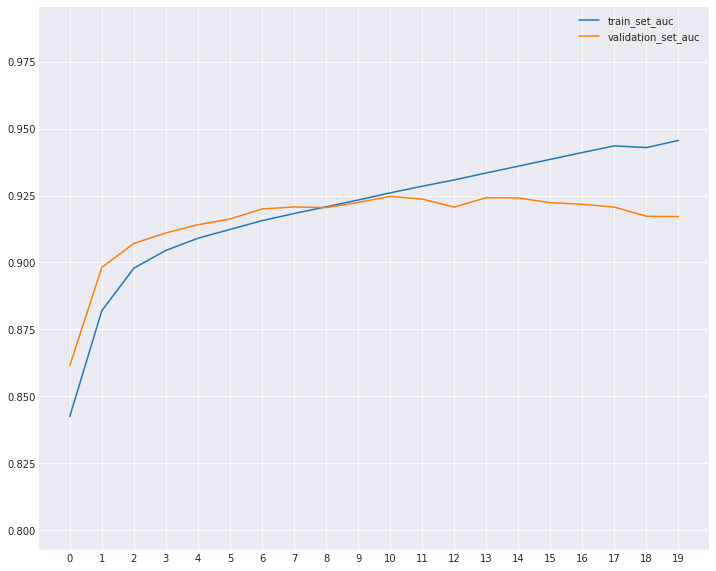

In [33]:
plot_history(history,scoring=["auc"])

In [34]:
best_model = tf.keras.models.Sequential([
    embedding,
    tf.keras.layers.LSTM(256),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(2, activation="softmax"),
])

best_model.compile(
    optimizer="adam",
    loss='categorical_crossentropy',
    metrics=['AUC',"accuracy"],
)

In [35]:
best_model.fit(X,Y,epochs=10,batch_size=1024,validation_data=(X_test,test_Y))

Epoch 1/10
1559/1559 [==============================] - 133s 85ms/step - loss: 0.4536 - auc: 0.8682 - accuracy: 0.7857 - val_loss: 0.4032 - val_auc: 0.8973 - val_accuracy: 0.8127
Epoch 2/10
1559/1559 [==============================] - 134s 86ms/step - loss: 0.3992 - auc: 0.9001 - accuracy: 0.8181 - val_loss: 0.3795 - val_auc: 0.9104 - val_accuracy: 0.8275
Epoch 3/10
1559/1559 [==============================] - 135s 87ms/step - loss: 0.3900 - auc: 0.9053 - accuracy: 0.8237 - val_loss: 0.3754 - val_auc: 0.9122 - val_accuracy: 0.8288
Epoch 4/10
1559/1559 [==============================] - 132s 85ms/step - loss: 0.3967 - auc: 0.9038 - accuracy: 0.8219 - val_loss: 0.3711 - val_auc: 0.9147 - val_accuracy: 0.8332
Epoch 5/10
1559/1559 [==============================] - 134s 86ms/step - loss: 0.3766 - auc: 0.9118 - accuracy: 0.8310 - val_loss: 0.3692 - val_auc: 0.9155 - val_accuracy: 0.8353
Epoch 6/10
1559/1559 [==============================] - 136s 87ms/step - loss: 0.3671 - auc: 0.9163 - acc

In [37]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

def show_result_binary(y_pred, y_pred_prob, y_true):
    print("accuracy score :",accuracy_score(y_test,y_pred))
    print("AUC score :",roc_auc_score(y_test,y_pred_prob[:,1]))
    cm = confusion_matrix(y_true,y_pred)
    print(classification_report(y_true,y_pred))
    return pd.DataFrame(cm,columns=["good","bad"],index=["good","bad"])

In [36]:
best_model.save("./data/final_model/w2v_model")

INFO:tensorflow:Assets written to: ./data/final_model/w2v_model/assets


INFO:tensorflow:Assets written to: ./data/final_model/w2v_model/assets


In [41]:
joblib.dump(tokenizer,"./data/final_model/tokenizer.pkl")

['./data/final_model/tokenizer.pkl']

In [38]:
y_pred_proba = best_model.predict(X_test)
y_pred = np.argmax(y_pred_proba,axis=1)

In [39]:
dic = {1:"good",0:"bad"}
y_pred = [dic[y] for y in y_pred] 

In [40]:
show_result_binary(y_pred,y_pred_proba,y_test)

accuracy score : 0.843
AUC score : 0.923564125
              precision    recall  f1-score   support

         bad       0.84      0.85      0.84      2000
        good       0.85      0.83      0.84      2000

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



,good,bad
good,1705,295
bad,333,1667


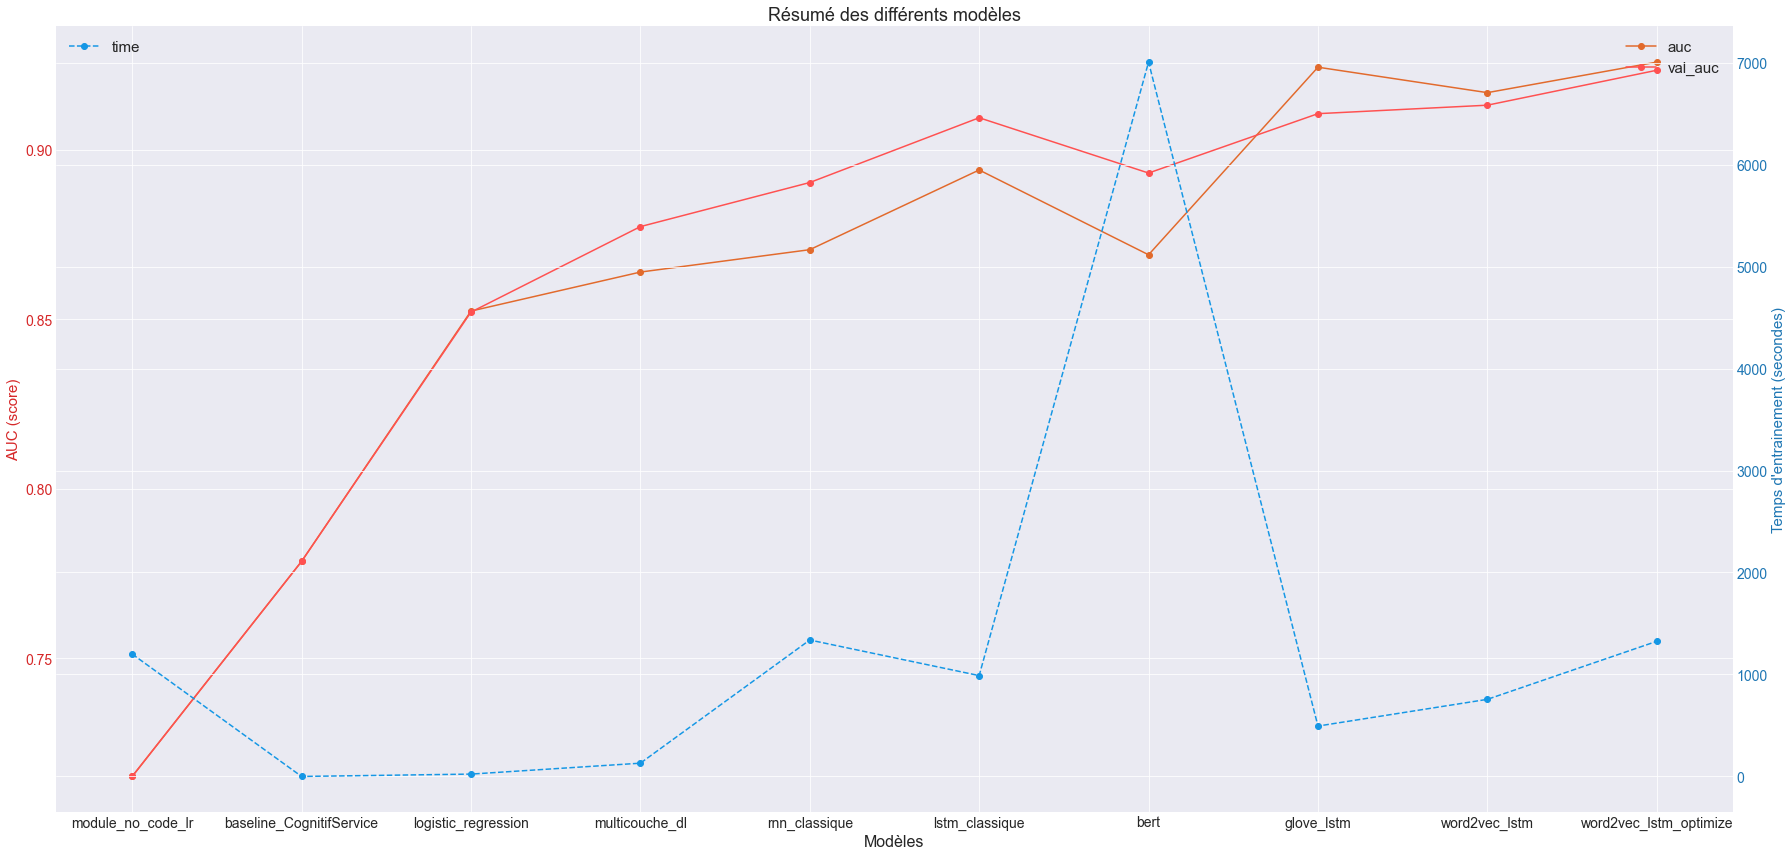

In [3]:
result_final = {
    "module_no_code_lr":{"auc":0.7152,"val_auc":0.7152,"nb_data":10000,"time":1200},
    "baseline_CognitifService":{"auc":0.7786,"val_auc":0.7786,"nb_data":0,"time":0},
    "logistic_regression":{"auc":0.8524,"val_auc":0.8521,"nb_data":1600000,"time":23},
    "multicouche_dl":{"auc":0.8639,"val_auc":0.8773,"nb_data":1280000,"time":130},
    "rnn_classique":{"auc":0.8705,"val_auc":0.8903,"nb_data":1280000,"time":1338},
    "lstm_classique":{"auc":0.8940,"val_auc":0.9094,"nb_data":1280000,"time":989},
    "bert":{"auc":0.8690,"val_auc":0.8931,"nb_data":1280000,"time":7005},
    "glove_lstm":{"auc":0.9243,"val_auc":0.9106,"nb_data":1280000,"time":494},
    "word2vec_lstm":{"auc":0.9168,"val_auc":0.9131,"nb_data":1280000,"time":756},
    # pour optimize on à entrainé sur tout le jeu de données "acc" puis test sur le jeu de test "val_acc" 
    "word2vec_lstm_optimize":{"auc":0.9258,"val_auc":0.9234,"nb_data":1600000,"time":1325},
}

fig, ax1 = plt.subplots(figsize=(25,12))
ax1.set_xlabel("Modèles",fontsize=16)
ax1.tick_params(axis='x',labelsize=14)
ax1.set_ylabel("AUC (score)",color='tab:red',fontsize=15)
ax1.plot([k for k in result_final.keys()],[v["auc"] for v in result_final.values()],label="auc",color="#E26A2C",marker="o")
ax1.plot([k for k in result_final.keys()],[v["val_auc"] for v in result_final.values()],label="val_auc",color="#FF5151",marker="o")
ax1.tick_params(axis='y', labelcolor='tab:red',labelsize=14)

ax2 = ax1.twinx()

ax2.plot([k for k in result_final.keys()],[v["time"] for v in result_final.values()],
         label="time",color="#1597E5",marker="o",ls="--")
ax2.set_ylabel('Temps d\'entrainement (secondes)', color='tab:blue',fontsize=15) 
ax2.tick_params(axis='y', labelcolor='tab:blue',labelsize=14)

plt.title("Résumé des différents modèles",fontsize=18)
ax1.legend(loc="upper right",fontsize=15)
ax2.legend(loc="upper left",fontsize=15)
fig.tight_layout()
plt.show()

On vois ici que ce dernier modèle est bien plus performant que le service cognitif sur la détection de sentiment des tweet, et malgré un bon score sur la détection des bad buzz du service cognitif, ce modèle est plus performant en tous point.

Pour le prix tout dépend de l'infrastructure mise en place, on tournera **aux alentours de 0.11€ d'utilisation CPU à l'heure sois 2.64€ MAXIMUM par jours**.

Si on prend le même comparatif de charge testé sur le service cognitif d'Azure, on se retrouve ici avec environ **0.11€ pour le test des 4000 tweet** maximum au lieux de **3,84€ pour le service cognitif pour la formule de base (S0)**.

# pipeline (pas utilisé)

In [43]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.base import BaseEstimator, TransformerMixin

class PadSequencesTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, maxlen):
        self.maxlen = maxlen

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_padded = pad_sequences(X, maxlen=self.maxlen)
        return X_padded
    


class TokenizerTransformer(BaseEstimator, TransformerMixin, Tokenizer):

    def __init__(self, **tokenizer_params):
        Tokenizer.__init__(self, **tokenizer_params)

    def fit(self, X, y=None):
        self.fit_on_texts(X)
        return self

    def transform(self, X, y=None):
        X_transformed = self.texts_to_sequences(X)
        return X_transformed
    
def create_best_model(num_unit=256):
    best_model = tf.keras.models.Sequential([
        embedding,
        tf.keras.layers.LSTM(num_unit),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(2, activation="softmax"),
    ])

    best_model.compile(
        optimizer="adam",
        loss='categorical_crossentropy',
        metrics=['AUC',"accuracy"],
    )
    return best_model

In [44]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline

my_tokenizer = TokenizerTransformer()
my_padder = PadSequencesTransformer(maxlen=300)
my_model = KerasClassifier(build_fn=create_best_model, epochs=12,batch_size=1024)

pipeline = Pipeline([
    ('tokenizer', my_tokenizer),
    ('padder', my_padder),
    ('model', my_model)
])

<ipython-input-44-2241a63a15a6>:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  my_model = KerasClassifier(build_fn=create_best_model, epochs=12,batch_size=1024)


In [37]:
X_train = df_nlp["text"]
y_train = df_nlp["sentiment"]
# on retire les données de test :
new_size=4000
size=new_size//2

pos_X = []
i = 1500000
while len(pos_X) < size:
    if y_train[i] =="good":
        pos_X.append(i)
    i+=1

i=700000
neg_X = []
while len(neg_X) < size:
    if y_train[i] =="bad":
        neg_X.append(i)
    i+=1
id_pos_test_set = pos_X
id_pos_test_set.extend(neg_X)


In [38]:
X_train.drop(id_pos_test_set,axis=0,inplace=True)
y_train.drop(id_pos_test_set,axis=0,inplace=True)
X_test = df_nlp["text"].loc[id_pos_test_set].tolist()
y_test = df_nlp["sentiment"].loc[id_pos_test_set].tolist()

X = [cleanning_data(sentence) for sentence in X_train]
Y = pd.get_dummies(y_train).values

In [82]:
pipeline.fit(X,Y)

Epoch 1/12
1559/1559 [==============================] - 133s 84ms/step - loss: 0.4496 - auc: 0.8707 - accuracy: 0.7883
Epoch 2/12
1559/1559 [==============================] - 137s 88ms/step - loss: 0.3975 - auc: 0.9010 - accuracy: 0.8186
Epoch 3/12
1559/1559 [==============================] - 140s 90ms/step - loss: 0.5334 - auc: 0.8309 - accuracy: 0.7573
Epoch 4/12
1559/1559 [==============================] - 132s 85ms/step - loss: 0.4126 - auc: 0.8936 - accuracy: 0.8119
Epoch 5/12
1559/1559 [==============================] - 134s 86ms/step - loss: 0.3808 - auc: 0.9096 - accuracy: 0.8286
Epoch 6/12
1559/1559 [==============================] - 132s 85ms/step - loss: 0.3723 - auc: 0.9138 - accuracy: 0.8331
Epoch 7/12
1559/1559 [==============================] - 133s 86ms/step - loss: 0.3664 - auc: 0.9167 - accuracy: 0.8359
Epoch 8/12
1559/1559 [==============================] - 135s 87ms/step - loss: 0.3611 - auc: 0.9191 - accuracy: 0.8387
Epoch 9/12
1559/1559 [==========================

Pipeline(steps=[('tokenizer', TokenizerTransformer()),
                ('padder', PadSequencesTransformer(maxlen=300)),
                ('model',
                 <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f3a00ca7320>)])

In [83]:
X_test = [cleanning_data(sentence) for sentence in X_test]

In [90]:
y_pred_proba = pipeline.predict_proba(X_test)
y_pred = pipeline.predict(X_test)
dic={1:"good",0:"bad"}
y_pred = [dic[y] for y in y_pred] 

In [91]:
show_result_binary(y_pred,y_pred_proba,y_test)

accuracy score : 0.84525
AUC score : 0.9231093749999999
              precision    recall  f1-score   support

         bad       0.85      0.84      0.84      2000
        good       0.84      0.85      0.85      2000

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



,good,bad
good,1671,329
bad,290,1710


### Sauvegarde de la méthode de clean, du tokenizer et du modèle entrainé 

In [93]:
import joblib
joblib.dump(pipeline, "./data/model/pipeline.joblib")

TypeError: can't pickle weakref objects

In [94]:
# On sauvegarde a part pour évité les erreurs
pipeline.named_steps['model'].model.save('./data/final_model/keras_model.h5')

# permet de sauvegarder correctement la pipeline (TypeError: can't pickle weakref objects)
pipeline.named_steps['model'].model = None

joblib.dump(pipeline,"./data/final_model/pipeline_best_model.pkl")

['./data/final_model/pipeline_best_model.pkl']